# Face-to-BMI
***
## Machine Learning II

By Amulya Jayanti | Halleluya Mengesha | Hira Stanley | Sami Naeem | Vaishnavi Kokadwar
  
*May, 2025*
***

# PART 2 - Models

## b) VGGFace - Second Best Model

In [ ]:
# !pip install pandas matplotlib
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_vggface.vggface import VGGFace

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("Keras VGGFace ready!")

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 14.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.3 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.9 MB/s eta 0:00:00
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [matplotlib]0 [matplotlib]
TensorFlow: 2.13.0
Keras VGGFace ready!


In [8]:
BASE_DIR   = r"/Users/amulyajayanti/Downloads/BMI/Data"
CSV_PATH   = os.path.join(BASE_DIR, "data.csv")
IMAGES_DIR = os.path.join(BASE_DIR, "Images")

df = pd.read_csv(CSV_PATH)
df["filepath"] = df["name"].apply(lambda fn: os.path.join(IMAGES_DIR, fn))
df = df[df["filepath"].apply(os.path.exists)]

train_df = df[df["is_training"] == 1]
test_df  = df[df["is_training"] == 0]

train_paths  = train_df["filepath"].tolist()
train_labels = train_df["bmi"].values
test_paths   = test_df["filepath"].tolist()
test_labels  = test_df["bmi"].values

IMG_SIZE, BATCH, AUTOTUNE = (224, 224), 32, tf.data.AUTOTUNE

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # universal decoder
    img.set_shape([None, None, 3])  # manually specify shape
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds = (tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
            .shuffle(len(train_paths))
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .batch(BATCH).prefetch(AUTOTUNE))

test_ds  = (tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .batch(BATCH).prefetch(AUTOTUNE))

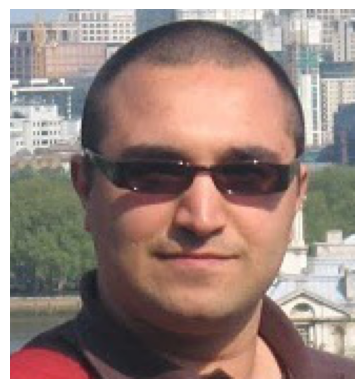

BMI: 34.2073961938


In [40]:
example_path = train_paths[0]
example_bmi = train_labels[0]
img = plt.imread(example_path)
plt.imshow(img)
plt.axis('off')
plt.show()
print("BMI:",example_bmi)

### i. Baseline model(VGG Face):

In [9]:
base = VGGFace(model="vgg16", include_top=False, input_shape=(224, 224, 3))
base.trainable = False          # freeze for baseline

inputs  = layers.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation="linear")(x)

model = Model(inputs, output)
model.compile(optimizer=Adam(1e-4), loss="mse", metrics=["mae"])
model.summary()

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=15,
                    callbacks=callbacks)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_____________________________________________

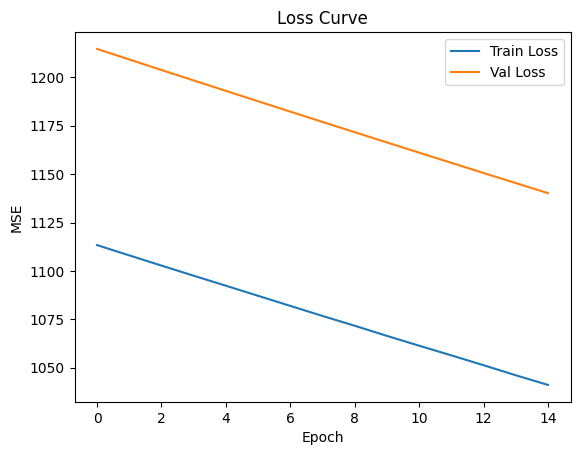

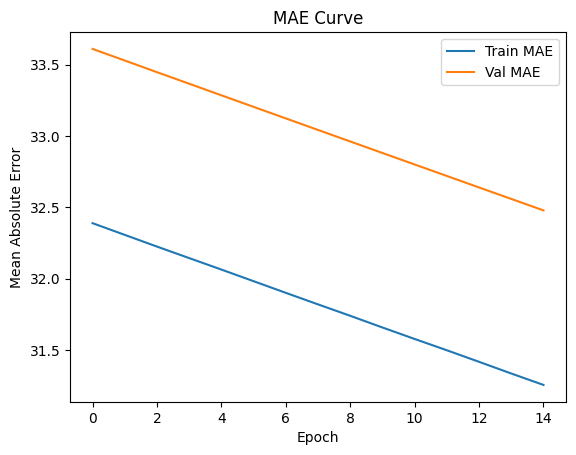

In [10]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Loss Curve')
plt.show()

plt.figure()
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE Curve')
plt.show()

In [11]:
model.save("vggface_bmi_model.h5")
print("✅ Model saved to vggface_bmi_model.h5")

✅ Model saved to vggface_bmi_model.h5


In [12]:
history.history["mae"]

[32.38926315307617,
 32.307193756103516,
 32.22511291503906,
 32.1445198059082,
 32.06402587890625,
 31.9825496673584,
 31.900957107543945,
 31.82001304626465,
 31.73996353149414,
 31.658021926879883,
 31.57756805419922,
 31.498308181762695,
 31.41737937927246,
 31.335405349731445,
 31.255420684814453]

In [13]:
from tensorflow.keras.models import load_model
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

# Custom objects needed by keras-vggface
custom_objects = {'VGGFace': VGGFace, 'utils': utils}

model = load_model("vggface_bmi_model.h5", custom_objects=custom_objects)
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [17]:
!pip install scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

y_true = np.array([])
y_pred = np.array([])
for batch in test_ds:
    imgs, labels = batch
    preds = model.predict(imgs)
    y_true = np.concatenate([y_true, labels.numpy()])
    y_pred = np.concatenate([y_pred, preds.flatten()])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
r, _ = pearsonr(y_true, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Pearson r: {r:.4f}")

  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 13.2 MB/s eta 0:00:0000:010:01
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
1/1 [==============================] - 1s 1s/step
MSE: 1140.17
MAE: 32.48
R² Score: -12.4307
Pearson r: -0.0934


### ii) Finetuning-1: Data Augmentation+ Unfreezing Block5

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
], name="data_augmentation")

In [22]:
for layer in base.layers:
    layer.trainable = 'block5' in layer.name
    
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='linear')(x)

model_aug_block5 = Model(inputs, outputs)
model_aug_block5.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-5), loss='mse', metrics=['mae'])

In [23]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

In [24]:
print("Training model with block5 unfrozen and augmentation...")
history_aug_block5 = model_aug_block5.fit(train_ds, validation_data=test_ds, epochs=15, callbacks=callbacks)

model_aug_block5.save("vggface_augmented_block5_finetuned.h5")
print(" Model saved: vggface_augmented_block5_finetuned.h5")

Training model with block5 unfrozen and augmentation...
Epoch 1/15
101/101 [==============================] - 378s 4s/step - loss: 1115.3280 - mae: 32.4206 - val_loss: 1218.9679 - val_mae: 33.6762 - lr: 1.0000e-05
Epoch 2/15
101/101 [==============================] - 461s 5s/step - loss: 1114.7911 - mae: 32.4124 - val_loss: 1218.4186 - val_mae: 33.6681 - lr: 1.0000e-05
Epoch 3/15
101/101 [==============================] - 495s 5s/step - loss: 1114.2693 - mae: 32.4043 - val_loss: 1217.8689 - val_mae: 33.6599 - lr: 1.0000e-05
Epoch 4/15
101/101 [==============================] - 448s 4s/step - loss: 1113.8157 - mae: 32.3972 - val_loss: 1217.3242 - val_mae: 33.6517 - lr: 1.0000e-05
Epoch 5/15
101/101 [==============================] - 430s 4s/step - loss: 1113.3003 - mae: 32.3893 - val_loss: 1216.7769 - val_mae: 33.6436 - lr: 1.0000e-05
Epoch 6/15
101/101 [==============================] - 429s 4s/step - loss: 1112.7515 - mae: 32.3809 - val_loss: 1216.2299 - val_mae: 33.6354 - lr: 1.0000e

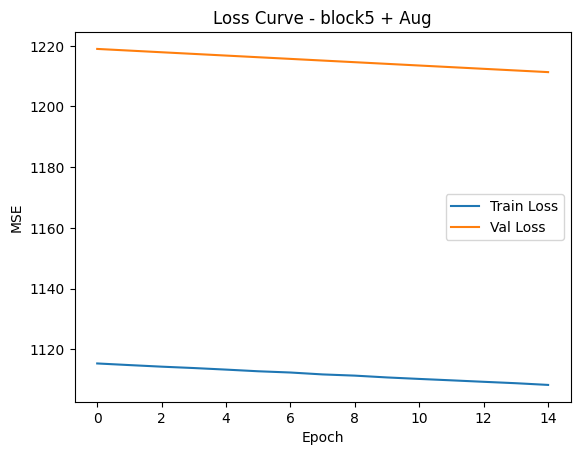

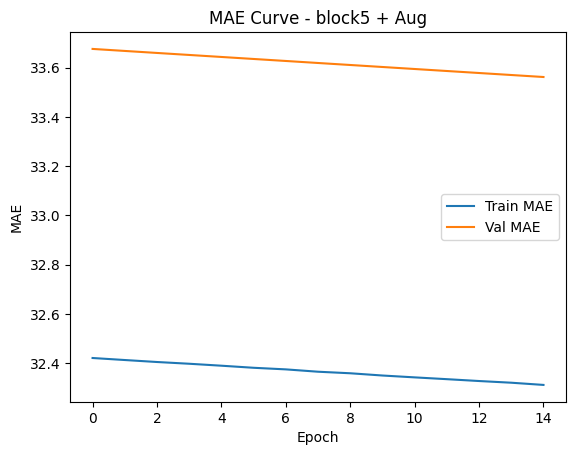

In [25]:
plt.figure()
plt.plot(history_aug_block5.history['loss'], label='Train Loss')
plt.plot(history_aug_block5.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Loss Curve - block5 + Aug')
plt.legend()
plt.figure()
plt.plot(history_aug_block5.history['mae'], label='Train MAE')
plt.plot(history_aug_block5.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE Curve - block5 + Aug')
plt.legend()
plt.show()

In [26]:
extractor = Model(inputs=model_aug_block5.input, outputs=model_aug_block5.layers[-3].output)

X_train = extractor.predict(
    tf.data.Dataset.from_tensor_slices(train_paths).map(lambda p: preprocess(p, 0)[0]).batch(BATCH)
)
X_test = extractor.predict(
    tf.data.Dataset.from_tensor_slices(test_paths).map(lambda p: preprocess(p, 0)[0]).batch(BATCH)
)
y_train = train_labels
y_test = test_labels

24/24 [==============================] - 85s 4s/step


In [32]:
print(history_aug_block5.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


In [33]:
!pip install scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

y_true = np.array([])
y_pred = np.array([])
for batch in test_ds:
    imgs, labels = batch
    preds = model_aug_block5.predict(imgs)
    y_true = np.concatenate([y_true, labels.numpy()])
    y_pred = np.concatenate([y_pred, preds.flatten()])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
r, _ = pearsonr(y_true, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Pearson r: {r:.4f}")

1/1 [==============================] - 1s 1s/step
MSE: 1211.32
MAE: 33.56
R² Score: -13.2689
Pearson r: -0.0217


In [70]:
model.save("model_aug_block5.h5")
print("✅ Model saved to model_aug_block5.h5")

✅ Model saved to model_aug_block5.h5


### iii) Finetuning-2: Data Augmentation + Unfreezing Block 4 and Block 5

In [34]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, Dropout, GlobalAveragePooling2D, Dense, Input

# Data augmentation
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
], name="data_augmentation")

In [35]:
# Build model
base = VGGFace(model="vgg16", include_top=False, input_shape=(224, 224, 3))
for layer in base.layers:
    layer.trainable = any(b in layer.name for b in ["block4", "block5"])

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='linear')(x)

model_aug_block45 = Model(inputs, outputs)
model_aug_block45.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-5), loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

In [36]:
print("Training model with block4 & block5 unfrozen and augmentation...")
history_aug_block45 = model_aug_block45.fit(train_ds, validation_data=test_ds, epochs=15, callbacks=callbacks)

# Save model
model_aug_block45.save("vggface_augmented_block4_block5_finetuned.h5")
print("Model saved to vggface_augmented_block4_block5_finetuned.h5")

Training model with block4 & block5 unfrozen and augmentation...
Epoch 1/15
101/101 [==============================] - 391s 4s/step - loss: 1116.4819 - mae: 32.4382 - val_loss: 1220.0399 - val_mae: 33.6922 - lr: 1.0000e-05
Epoch 2/15
101/101 [==============================] - 463s 5s/step - loss: 1115.9736 - mae: 32.4305 - val_loss: 1219.4919 - val_mae: 33.6840 - lr: 1.0000e-05
Epoch 3/15
101/101 [==============================] - 487s 5s/step - loss: 1115.4396 - mae: 32.4223 - val_loss: 1218.9431 - val_mae: 33.6758 - lr: 1.0000e-05
Epoch 4/15
101/101 [==============================] - 492s 5s/step - loss: 1114.9420 - mae: 32.4147 - val_loss: 1218.3960 - val_mae: 33.6677 - lr: 1.0000e-05
Epoch 5/15
101/101 [==============================] - 485s 5s/step - loss: 1114.4287 - mae: 32.4067 - val_loss: 1217.8513 - val_mae: 33.6596 - lr: 1.0000e-05
Epoch 6/15
101/101 [==============================] - 496s 5s/step - loss: 1113.9198 - mae: 32.3988 - val_loss: 1217.3066 - val_mae: 33.6515 - lr

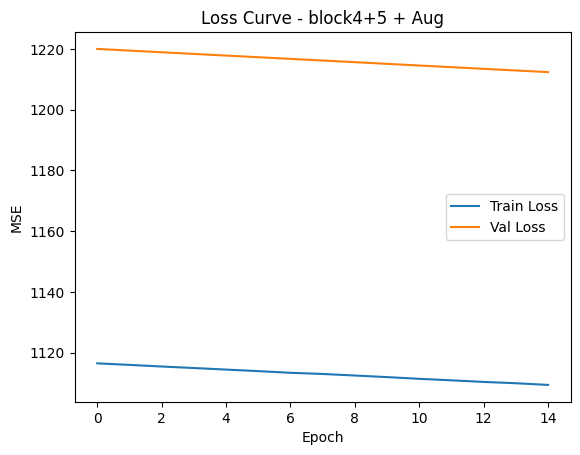

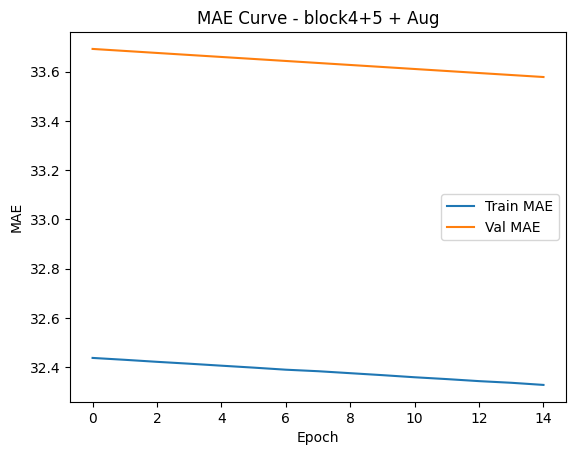

In [37]:
plt.figure()
plt.plot(history_aug_block45.history['loss'], label='Train Loss')
plt.plot(history_aug_block45.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Loss Curve - block4+5 + Aug')
plt.legend()
plt.figure()
plt.plot(history_aug_block45.history['mae'], label='Train MAE')
plt.plot(history_aug_block45.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE Curve - block4+5 + Aug')
plt.legend()
plt.show()

### iv) Feature Extractor(fc6 as suggested in paper) + Regressor

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

BASE_DIR = "/Users/amulyajayanti/Downloads/BMI/Data"
CSV_PATH = os.path.join(BASE_DIR, "data.csv")
IMAGES_DIR = os.path.join(BASE_DIR, "Images")
MODEL_PATH = "vggface_augmented_block4_block5_finetuned.h5"

df = pd.read_csv(CSV_PATH)
df["filepath"] = df["name"].apply(lambda fn: os.path.join(IMAGES_DIR, fn))
df = df[df["filepath"].apply(os.path.exists)].reset_index(drop=True)

train_df = df[df["is_training"] == 1]
test_df  = df[df["is_training"] == 0]

train_paths  = train_df["filepath"].tolist()
train_labels = train_df["bmi"].values
test_paths   = test_df["filepath"].tolist()
test_labels  = test_df["bmi"].values
test_genders = test_df["gender"].values

In [46]:
# Load fine-tuned model & extract fc6 features
model = load_model(MODEL_PATH)
extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

# Only extract images for prediction
train_imgs = tf.data.Dataset.from_tensor_slices(train_paths).map(lambda p: preprocess(p, 0)[0]).batch(BATCH)
test_imgs  = tf.data.Dataset.from_tensor_slices(test_paths).map(lambda p: preprocess(p, 0)[0]).batch(BATCH)

X_train = extractor.predict(train_imgs)
X_test  = extractor.predict(test_imgs)
y_train = train_labels
y_test  = test_labels

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

24/24 [==============================] - 69s 3s/step


In [47]:
# Define regressors
regressors = {
    "Ridge": Ridge(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0)
}

# Train, predict, evaluate
results = []
for name, reg in regressors.items():
    reg.fit(X_train_scaled, y_train)
    y_pred = reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)
    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "Pearson r": r
    })

results_df = pd.DataFrame(results)
print("\n Model Evaluation Results:")
print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 3210, number of used features: 512
[LightGBM] [Info] Start training from score 32.434370


/opt/anaconda3/envs/bmi_new_vgg/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



 Model Evaluation Results:
           Model        MSE       MAE        R²  Pearson r
0          Ridge  56.333627  5.543402  0.336415   0.589562
1            SVR  61.292173  5.500685  0.278005   0.614704
2  Random Forest  58.792040  5.581864  0.307456   0.564264
3            KNN  71.570796  6.186713  0.156928   0.417479
4        XGBoost  59.343857  5.512516  0.300956   0.562017
5       LightGBM  53.551898  5.144377  0.369182   0.613432
6       CatBoost  52.362116  5.096386  0.383197   0.627984


In [48]:
# Gender-wise Pearson r 
gender_df = pd.DataFrame({
    "bmi_true": y_test,
    "bmi_pred": regressors["CatBoost"].predict(X_test_scaled),
    "gender": test_genders
})
r_male = pearsonr(
    gender_df[gender_df["gender"] == "Male"]["bmi_true"],
    gender_df[gender_df["gender"] == "Male"]["bmi_pred"]
)[0]
r_female = pearsonr(
    gender_df[gender_df["gender"] == "Female"]["bmi_true"],
    gender_df[gender_df["gender"] == "Female"]["bmi_pred"]
)[0]

print(f"\n Pearson r (Male):   {r_male:.4f}")
print(f"Pearson r (Female): {r_female:.4f}")


 Pearson r (Male):   0.6477
Pearson r (Female): 0.6099


### v) Feature Extractor(fc6) + Gender included + Regressors

In [49]:
BASE_DIR = "/Users/amulyajayanti/Downloads/BMI/Data"
CSV_PATH = os.path.join(BASE_DIR, "data.csv")
IMAGES_DIR = os.path.join(BASE_DIR, "Images")
MODEL_PATH = "vggface_augmented_block4_block5_finetuned.h5"

# --- Load Data ---
df = pd.read_csv(CSV_PATH)
df["filepath"] = df["name"].apply(lambda fn: os.path.join(IMAGES_DIR, fn))
df = df[df["filepath"].apply(os.path.exists)].reset_index(drop=True)

train_df = df[df["is_training"] == 1]
test_df  = df[df["is_training"] == 0]

train_paths  = train_df["filepath"].tolist()
train_labels = train_df["bmi"].values
test_paths   = test_df["filepath"].tolist()
test_labels  = test_df["bmi"].values
train_genders = train_df["gender"].values.reshape(-1, 1)
test_genders  = test_df["gender"].values.reshape(-1, 1)

# --- Load Fine-tuned Model and Extractor (fc6) ---
model = load_model(MODEL_PATH)
extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

In [50]:
IMG_SIZE = (224, 224)
BATCH = 32

def preprocess_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

train_imgs = tf.data.Dataset.from_tensor_slices(train_paths).map(lambda p: preprocess_img(p)).batch(BATCH)
test_imgs  = tf.data.Dataset.from_tensor_slices(test_paths).map(lambda p: preprocess_img(p)).batch(BATCH)

X_train = extractor.predict(train_imgs)
X_test  = extractor.predict(test_imgs)

24/24 [==============================] - 70s 3s/step


In [52]:
from sklearn.preprocessing import OneHotEncoder

# --- Normalize Image Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- One-hot Encode Gender ---
gender_encoder = OneHotEncoder(sparse_output=False, drop=None)
gender_train_oh = gender_encoder.fit_transform(train_genders)
gender_test_oh  = gender_encoder.transform(test_genders)

# --- Concatenate Gender + Image Features ---
X_train_combined = np.concatenate([X_train_scaled, gender_train_oh], axis=1)
X_test_combined  = np.concatenate([X_test_scaled, gender_test_oh], axis=1)
y_train = train_labels
y_test  = test_labels

In [53]:
# --- Define Regressors ---
regressors = {
    "Ridge": Ridge(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0)
}

# --- Train and Evaluate ---
results = []
for name, reg in regressors.items():
    reg.fit(X_train_combined, y_train)
    y_pred = reg.predict(X_test_combined)
    mae = mean_absolute_error(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)
    results.append({
        "Model": name,
        "MAE": mae,
        "Pearson r": r
    })

results_df = pd.DataFrame(results)
print("\n Model Evaluation Results with Gender Included:")
print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130564
[LightGBM] [Info] Number of data points in the train set: 3210, number of used features: 514
[LightGBM] [Info] Start training from score 32.434370


/opt/anaconda3/envs/bmi_new_vgg/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



 Model Evaluation Results with Gender Included:
           Model       MAE  Pearson r
0          Ridge  5.540642   0.589693
1            SVR  5.500560   0.614630
2  Random Forest  5.587093   0.563321
3            KNN  6.171406   0.420439
4        XGBoost  5.511062   0.560586
5       LightGBM  5.144747   0.609769
6       CatBoost  5.120939   0.625423


### vi) Ensemble Method on best performers

In [59]:
!pip install tqdm
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from tqdm import tqdm

# --- Step 1: Sort results_df by Pearson r and pick top-k models ---
top_k = 4 
top_models = results_df.sort_values(by="Pearson r", ascending=False).head(top_k)["Model"].tolist()

# --- Step 2: model instances
model_mapping = {
    "Ridge": Ridge(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0)
}

# --- Step 3: Prepare base learners for stacking ---
base_learners = [(name.lower().replace(" ", "_"), model_mapping[name]) for name in top_models]

# --- Step 4: Meta-learner ---
meta_learner = Ridge(alpha=1.0)

# --- Step 5: Stacking Regressor ---
ensemble = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# --- Step 6: Train the ensemble ---
print(f"\n Training stacking ensemble with top-{top_k} base models: {top_models}")
with tqdm(total=1, desc="Ensemble Training", bar_format="{desc}: {bar} {percentage:3.0f}%") as pbar:
    ensemble.fit(X_train_combined, y_train)
    pbar.update(1)

# --- Step 7: Predict and evaluate ---
# Ensure all are clean numpy arrays
y_test = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()
g_test = np.array(test_genders).flatten()

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r_all, _ = pearsonr(y_test, y_pred)
r_male, _ = pearsonr(y_test[g_test == "Male"], y_pred[g_test == "Male"])
r_female, _ = pearsonr(y_test[g_test == "Female"], y_pred[g_test == "Female"])

print("\nEnsemble Stacking Regressor")
print(f" MAE: {mae:.2f}")
print(f" Pearson r (Overall): {r_all:.3f}")
print(f" Pearson r (Male):    {r_male:.3f}")
print(f" Pearson r (Female):  {r_female:.3f}")


 Training stacking ensemble with top-4 base models: ['CatBoost', 'SVR', 'LightGBM', 'Ridge']


Ensemble Training:                                                                                                            0%

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 2568, number of used features: 514
[LightGBM] [Info] Total Bins 130564
[LightGBM] [Info] Start training from score 32.478246
[LightGBM] [Info] Number of data points in the train set: 2568, number of used features: 514
[LightGBM] [Info] Start training from score 32.329248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021402 seconds.
You can set `force_col_wise=true` to remove 

/opt/anaconda3/envs/bmi_new_vgg/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/bmi_new_vgg/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/bmi_new_vgg/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/bmi_new_vgg/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/bmi_new_vgg/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor wa


Ensemble Stacking Regressor
 MAE: 5.04
 Pearson r (Overall): 0.641
 Pearson r (Male):    0.653
 Pearson r (Female):  0.631


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130564
[LightGBM] [Info] Number of data points in the train set: 3210, number of used features: 514
[LightGBM] [Info] Start training from score 32.434370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130564
[LightGBM] [Info] Number of data points in the train set: 3210, number of used features: 514
[LightGBM] [Info] Start training from score 32.434370
